## 1. Control the RNAs which do have *rfdist files -- RNA models do run with some RNAs

In [ ]:
#!/usr/bin/env python3
"""
Diagnostic: List RNA families with/without .rfdist files
"""

import os
from os.path import join, isdir, isfile

DIR_WORKING   = "/Users/u7875558/RNAPhylo/seedAlignment_AllModels"
DIR_OUTPUTS   = join(DIR_WORKING, "outputs")
DIR_RF        = join(DIR_OUTPUTS, "251121_Robinson_Foulds")
DIR_DNA_extra = join(DIR_RF, "DNA_extra")

print("="*70)
print("DIAGNOSTIC: RNA families .rfdist file status")
print("="*70)

# Check DNA_extra folder
print("\n[DNA_extra folder]")
if isdir(DIR_DNA_extra):
    rna_dirs = sorted([d for d in os.listdir(DIR_DNA_extra) if isdir(join(DIR_DNA_extra, d))])
    has_rfdist = []
    missing_rfdist = []
    
    for rna in rna_dirs:
        rfdist_path = join(DIR_DNA_extra, rna, f"{rna}.rfdist")
        if isfile(rfdist_path):
            has_rfdist.append(rna)
        else:
            missing_rfdist.append(rna)
    
    print(f"Total RNA families: {len(rna_dirs)}")
    print(f"✓ WITH .rfdist: {len(has_rfdist)}")
    if missing_rfdist:
        print(f"✗ WITHOUT .rfdist: {len(missing_rfdist)}")
        for rna in missing_rfdist:
            print(f"    - {rna}")
else:
    print(f"✗ Directory not found: {DIR_DNA_extra}")

# Check S* model folders
print("\n[S* model folders]")
models = sorted([m for m in os.listdir(DIR_RF) if isdir(join(DIR_RF, m)) and m.startswith('S')])

for model in models:
    model_dir = join(DIR_RF, model)
    rna_dirs = sorted([d for d in os.listdir(model_dir) if isdir(join(model_dir, d))])
    
    has_rfdist = []
    missing_rfdist = []
    
    for rna in rna_dirs:
        rfdist_path = join(model_dir, rna, f"{rna}.rfdist")
        if isfile(rfdist_path):
            has_rfdist.append(rna)
        else:
            missing_rfdist.append(rna)
    
    print(f"\n{model}:")
    print(f"  Total RNA families: {len(rna_dirs)}")
    print(f"  ✓ WITH .rfdist: {len(has_rfdist)}")
    if missing_rfdist:
        print(f"  ✗ WITHOUT .rfdist: {len(missing_rfdist)}")
        for rna in missing_rfdist:
            print(f"      - {rna}")

print("\n" + "="*70)


## 2. Compute median normalised Robinson-Foulds distances and p values between DNA vs RNA

In [1]:
#!/usr/bin/env python3
"""
Compute Mann–Whitney U-test p-values for normalised RF distances (SEED dataset).
Per-model FDR correction; output: long/wide CSVs + median normalised RF data.

Consolidated cell: processes all models, RNAs; generates CSV outputs; applies FDR.
"""

import os
import sys
import csv
import glob
import logging
from os.path import join, isdir, isfile, exists
from datetime import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
from Bio import Phylo
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# ─── PATHS ────────────────────────────────────────────────────────────────────
DIR_WORKING   = "/Users/u7875558/RNAPhylo/seedAlignment_AllModels"
DIR_OUTPUTS   = join(DIR_WORKING, "outputs")
DIR_TREES     = join(DIR_OUTPUTS, "inferred_trees")
DIR_DNA       = join(DIR_TREES, "DNA")
DIR_RF        = join(DIR_OUTPUTS, "251121_Robinson_Foulds")
DIR_DNA_extra = join(DIR_RF, "DNA_extra")
LOG_DIR       = join(DIR_OUTPUTS, "logs", "RF_distance")

os.makedirs(LOG_DIR, exist_ok=True)

# ─── LOGGING ──────────────────────────────────────────────────────────────────
log_file = join(LOG_DIR, f"computePVal_SEED_UTest_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler(log_file), logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# ─── CONSTANTS ────────────────────────────────────────────────────────────────
ALPHA = 0.05
DO_FDR = True
DO_BONFERRONI = False

# ─── HELPER FUNCTIONS ─────────────────────────────────────────────────────────
def choose_first_existing(pattern_list):
    """Return first existing file/dir from list of candidate paths."""
    for p in pattern_list:
        if exists(p):
            return p
    return None

def read_rfdist_matrix(path: str) -> np.ndarray:
    """Read IQ-TREE tab/space-separated distance matrix."""
    if not isfile(path):
        return np.array([])
    try:
        with open(path, 'r') as f:
            lines = f.readlines()
        rows = []
        for line in lines[1:]:  # skip header
            parts = line.strip().split()
            if len(parts) > 1:
                rows.append(list(map(float, parts[1:])))  # skip row label
        return np.array(rows, dtype=float) if rows else np.array([])
    except Exception as e:
        logger.warning(f"Error reading {path}: {e}")
        return np.array([])

def normalize_rf_matrix_by_n(mat: np.ndarray, n_taxa: int) -> np.ndarray:
    """Normalize RF distances: nRF = RF / (2*(n-3)) for unrooted binary trees."""
    if mat.size == 0 or n_taxa < 4:
        return np.array([])
    # Check if already normalized (max ≤ 1)
    if np.nanmax(mat) <= 1.0 + 1e-9:
        return mat.copy()
    denom = 2 * (n_taxa - 3)
    return mat / denom if denom > 0 else mat.copy()

def count_taxa(tree_path: str) -> int | None:
    """Count terminals in Newick tree."""
    try:
        with open(tree_path, 'r') as fh:
            tree = next(Phylo.parse(fh, 'newick'))
        return len(tree.get_terminals())
    except Exception as e:
        logger.debug(f"Error counting taxa in {tree_path}: {e}")
        return None

# ─── MAIN COMPUTATION ─────────────────────────────────────────────────────────
def process_one_rna(rna, model, model_rf_dir, dna_rf_dir, dna_taxa_dir):
    """
    Process one RNA × Model pair: read RF matrices, normalize, U-test.
    Returns: dict with test results, or None if skipped.
    """
    rna_model_rf = join(model_rf_dir, rna)
    rna_dna_rf = join(dna_rf_dir, rna)

    # Find RF distance files
    # For model: looking for .rfdist file (RF distance matrix)
    # NOTE: .dna and .rna files contain 10 concatenated Newick trees, NOT distance matrices
    model_rfdist = choose_first_existing([
        join(rna_model_rf, f"{rna}.rfdist"),
        join(rna_model_rf, f"{rna}.txt")
    ])
    # For DNA baseline: looking for .rfdist file (RF distance matrix)
    dna_rfdist = choose_first_existing([
        join(rna_dna_rf, f"{rna}.rfdist"),
        join(rna_dna_rf, f"{rna}.txt")
    ])

    if not model_rfdist or not dna_rfdist:
        logger.info(f"[SKIP {model}/{rna}] Missing RF distance files")
        return None

    # Read matrices
    mat_model = read_rfdist_matrix(model_rfdist)
    mat_dna = read_rfdist_matrix(dna_rfdist)

    if mat_model.size == 0 or mat_dna.size == 0:
        logger.info(f"[SKIP {model}/{rna}] Empty RF matrices")
        return None

    # Count taxa
    tree_pattern = join(dna_taxa_dir, rna, "RAxML_bestTree.*")
    tree_file = choose_first_existing([
        t for t in glob.glob(tree_pattern) if isfile(t)
    ])

    if not tree_file or not isfile(tree_file):
        logger.info(f"[SKIP {model}/{rna}] No tree found for taxa count")
        return None

    n_taxa = count_taxa(tree_file)
    if n_taxa is None or n_taxa < 4:
        logger.info(f"[SKIP {model}/{rna}] Invalid taxa count: {n_taxa}")
        return None

    # Normalize matrices
    mat_model_norm = normalize_rf_matrix_by_n(mat_model, n_taxa)
    mat_dna_norm = normalize_rf_matrix_by_n(mat_dna, n_taxa)

    if mat_model_norm.size == 0 or mat_dna_norm.size == 0:
        logger.info(f"[SKIP {model}/{rna}] Normalization failed")
        return None

    # Extract distance arrays (lower triangle)
    dna_vals = mat_dna_norm[np.tril_indices_from(mat_dna_norm, k=-1)]
    model_vals = mat_model_norm[np.tril_indices_from(mat_model_norm, k=-1)]

    if len(dna_vals) < 1 or len(model_vals) < 1:
        logger.info(f"[SKIP {model}/{rna}] Insufficient distance values")
        return None

    # Mann–Whitney U-test
    U, p_raw = mannwhitneyu(dna_vals, model_vals, alternative='two-sided')

    dna_median = np.median(dna_vals)
    model_median = np.median(model_vals)

    return {
        'RNA': rna,
        'Model': model,
        'Category': 'DNA vs extra DNA' if model == 'DNA_extra' else 'DNA vs RNA',
        'DNA_median': dna_median,
        'Model_median': model_median,
        'pvalue_raw': p_raw,
        'U_statistic': U,
        'n_dna_vals': len(dna_vals),
        'n_model_vals': len(model_vals),
        'n_taxa': n_taxa
    }

# Collect results per model
all_results = []
models = sorted([m for m in os.listdir(DIR_RF) if isdir(join(DIR_RF, m)) and m.startswith('S')])

for model in models:
    model_rf_dir = join(DIR_RF, model)
    rna_dirs = sorted(set(d for d in os.listdir(model_rf_dir) if isdir(join(model_rf_dir, d))))

    model_results = []
    for rna in rna_dirs:
        # Use DIR_DNA_extra as the DNA baseline
        res = process_one_rna(rna, model, model_rf_dir, DIR_DNA_extra, DIR_DNA)
        if res:
            model_results.append(res)

    # Per-model FDR correction
    if model_results and DO_FDR:
        pvals = np.array([r['pvalue_raw'] for r in model_results], dtype=float)
        reject, qvals, _, _ = multipletests(pvals, alpha=ALPHA, method='fdr_bh')
        for i, r in enumerate(model_results):
            r['q_value'] = qvals[i]
            r['sig_fdr'] = reject[i]

    all_results.extend(model_results)
    logger.info(f"Processed {model}: {len(model_results)} RNAs")

# Output dataframes
if all_results:
    df_long = pd.DataFrame(all_results)
    df_medians = df_long[['RNA', 'Model', 'Category', 'DNA_median', 'Model_median']].copy()
    df_medians.columns = ['RNA', 'Model', 'Category', 'DNA_nRF_median', 'Model_nRF_median']

    # Wide format
    df_wide = df_long.pivot_table(
        index='RNA',
        columns='Model',
        values=['DNA_median', 'Model_median', 'pvalue_raw', 'q_value'],
        aggfunc='first'
    )

    # Rename for clarity and export
    seed_long = df_long.copy()
    seed_medians = df_medians.copy()
    seed_medians['Median nRF'] = seed_medians['Model_nRF_median']
    seed_wide = df_wide

    # Save CSV files
    output_csv_long = join(DIR_OUTPUTS, 'SEED_Utest_all_models_long.csv')
    output_csv_wide = join(DIR_OUTPUTS, 'SEED_Utest_all_models_wide.csv')
    output_csv_medians = join(DIR_OUTPUTS, 'SEED_Median_nRF_all_models_long.csv')

    df_long.to_csv(output_csv_long, index=False)
    df_wide.to_csv(output_csv_wide)
    seed_medians.to_csv(output_csv_medians, index=False)

    logger.info(f"Saved: {output_csv_long} ({len(df_long)} rows)")
    logger.info(f"Saved: {output_csv_wide}")
    logger.info(f"Saved: {output_csv_medians} ({len(seed_medians)} rows)")

    print(f"\n✓ Completed: {len(all_results)} RNAs processed across {len(models)} models")
    print(f"✓ Output CSV files saved to {DIR_OUTPUTS}")
else:
    print(f"✗ ERROR: No results processed. Check data paths and RF distance files.")


2025-12-02 11:32:30,463 - INFO - [SKIP S16/RF00207] Missing RF distance files
2025-12-02 11:32:32,130 - INFO - [SKIP S16/RF00976] Missing RF distance files
2025-12-02 11:32:32,320 - INFO - [SKIP S16/RF01047] Missing RF distance files
2025-12-02 11:32:33,080 - INFO - [SKIP S16/RF01338] Missing RF distance files
2025-12-02 11:32:33,095 - INFO - [SKIP S16/RF01380] Missing RF distance files
2025-12-02 11:32:35,749 - INFO - [SKIP S16/RF03623] Missing RF distance files
2025-12-02 11:32:35,803 - INFO - [SKIP S16/RF03760] Missing RF distance files
2025-12-02 11:32:35,890 - INFO - [SKIP S16/RF03969] Missing RF distance files
2025-12-02 11:32:36,230 - INFO - Processed S16: 1788 RNAs
2025-12-02 11:32:36,536 - INFO - [SKIP S16A/RF00207] Missing RF distance files
2025-12-02 11:32:37,591 - INFO - [SKIP S16A/RF00976] Missing RF distance files
2025-12-02 11:32:37,674 - INFO - [SKIP S16A/RF01047] Missing RF distance files
2025-12-02 11:32:37,941 - INFO - [SKIP S16A/RF01338] Missing RF distance files
20


✓ Completed: 25032 RNAs processed across 14 models
✓ Output CSV files saved to /Users/u7875558/RNAPhylo/seedAlignment_AllModels/outputs


## 3. Compute normalised RF distances between DNA vs DNA_extra

In [2]:
#!/usr/bin/env python3
"""
Compute median normalised RF distances for DNA_extra (DNA vs DNA_extra)
Append results to seed_medians, and save all median nRF data to CSV
"""

import os
import glob
import numpy as np
import pandas as pd
from os.path import join, isdir, isfile
from Bio import Phylo

# ─── PATHS ────────────────────────────────────────────────────────────────────
DIR_WORKING   = "/Users/u7875558/RNAPhylo/seedAlignment_AllModels"
DIR_OUTPUTS   = join(DIR_WORKING, "outputs")
DIR_TREES     = join(DIR_OUTPUTS, "inferred_trees")
DIR_DNA       = join(DIR_TREES, "DNA")
DIR_RF        = join(DIR_OUTPUTS, "251121_Robinson_Foulds")
DIR_DNA_extra = join(DIR_RF, "DNA_extra")

# ─── HELPER FUNCTIONS ─────────────────────────────────────────────────────────
def choose_first_existing(pattern_list):
    """Return first existing file/dir from list of candidate paths."""
    for p in pattern_list:
        if isfile(p):
            return p
    return None

def read_rfdist_matrix(path: str) -> np.ndarray:
    """Read IQ-TREE tab/space-separated distance matrix."""
    if not isfile(path):
        return np.array([])
    try:
        with open(path, 'r') as f:
            lines = f.readlines()
        rows = []
        for line in lines[1:]:  # skip header
            parts = line.strip().split()
            if len(parts) > 1:
                rows.append(list(map(float, parts[1:])))  # skip row label
        return np.array(rows, dtype=float) if rows else np.array([])
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return np.array([])

def normalize_rf_matrix_by_n(mat: np.ndarray, n_taxa: int) -> np.ndarray:
    """Normalize RF distances: nRF = RF / (2*(n-3)) for unrooted binary trees."""
    if mat.size == 0 or n_taxa < 4:
        return np.array([])
    if np.nanmax(mat) <= 1.0 + 1e-9:  # already normalized
        return mat.copy()
    denom = 2 * (n_taxa - 3)
    return mat / denom if denom > 0 else mat.copy()

def count_taxa(tree_path: str) -> int | None:
    """Count terminals in Newick tree."""
    try:
        with open(tree_path, 'r') as fh:
            tree = next(Phylo.parse(fh, 'newick'))
        return len(tree.get_terminals())
    except Exception:
        return None

# ─── PROCESS DNA_EXTRA ─────────────────────────────────────────────────────────
print("="*70)
print("Processing DNA_extra for median normalised RF distances")
print("="*70)

dna_extra_results = []

if isdir(DIR_DNA_extra):
    rna_dirs = sorted([d for d in os.listdir(DIR_DNA_extra) if isdir(join(DIR_DNA_extra, d))])
    
    for rna in rna_dirs:
        # Read RF distance matrices (DNA vs DNA_extra)
        dna_rfdist = choose_first_existing([
            join(DIR_DNA_extra, rna, f"{rna}.rfdist"),
            join(DIR_DNA_extra, rna, f"{rna}.txt")
        ])
        
        if not dna_rfdist:
            print(f"[SKIP {rna}] No .rfdist file found")
            continue
        
        # Read matrix
        mat = read_rfdist_matrix(dna_rfdist)
        if mat.size == 0:
            print(f"[SKIP {rna}] Empty RF matrix")
            continue
        
        # Count taxa from DNA tree
        tree_pattern = join(DIR_DNA, rna, "RAxML_bestTree.*")
        tree_file = choose_first_existing(glob.glob(tree_pattern))
        
        if not tree_file:
            print(f"[SKIP {rna}] No tree found for taxa count")
            continue
        
        n_taxa = count_taxa(tree_file)
        if n_taxa is None or n_taxa < 4:
            print(f"[SKIP {rna}] Invalid taxa count: {n_taxa}")
            continue
        
        # Normalize matrix
        mat_norm = normalize_rf_matrix_by_n(mat, n_taxa)
        if mat_norm.size == 0:
            print(f"[SKIP {rna}] Normalization failed")
            continue
        
        # Extract lower triangle (pairwise distances)
        vals = mat_norm[np.tril_indices_from(mat_norm, k=-1)]
        if len(vals) < 1:
            print(f"[SKIP {rna}] No distance values")
            continue
        
        # Compute median
        median_nrf = np.median(vals)
        
        dna_extra_results.append({
            'RNA': rna,
            'Model': 'DNA_extra',
            'Category': 'DNA vs extra DNA',
            'DNA_nRF_median': np.median(vals),
            'Model_nRF_median': median_nrf,
            'Median nRF': median_nrf,
            'n_taxa': n_taxa
        })
        
        print(f"✓ {rna}: median nRF = {median_nrf:.4f}")
    
    print(f"\n✓ Processed {len(dna_extra_results)} RNA families from DNA_extra")
else:
    print(f"✗ Directory not found: {DIR_DNA_extra}")

# ─── APPEND TO seed_medians ───────────────────────────────────────────────────
if dna_extra_results:
    # First, remove existing DNA_extra rows to avoid duplicates (in case cell is re-run)
    seed_medians = seed_medians[seed_medians['Model'] != 'DNA_extra'].copy()
    
    df_dna_extra = pd.DataFrame(dna_extra_results)
    seed_medians = pd.concat([seed_medians, df_dna_extra], ignore_index=True)
    print(f"\n✓ Appended DNA_extra to seed_medians (duplicate rows removed)")
    print(f"  New total rows: {len(seed_medians)}")
    print(f"  DNA_extra rows: {len(df_dna_extra)}")
else:
    print("\n✗ No DNA_extra data to append")

# ─── CREATE COMPARISON COLUMN AND SAVE TO CSV ─────────────────────────────────
print("\n" + "="*70)
print("Creating CSV with median normalised RF distances")
print("="*70)

# Create 'Comparison' column from Model and Category
def create_comparison(row):
    """Create comparison label from Model and Category."""
    if row['Category'] == 'DNA vs extra DNA':
        return 'DNA vs DNA_extra'
    elif row['Category'] == 'DNA vs RNA':
        return f"DNA vs {row['Model']}"
    else:
        return f"{row['Category']}"

seed_medians['Comparison'] = seed_medians.apply(create_comparison, axis=1)

# Select and reorder columns for output CSV
output_df = seed_medians[['RNA', 'Comparison', 'Median nRF']].copy()

# Save to CSV
output_csv = join(DIR_OUTPUTS, 'SEED_Median_nRF_with_DNA_extra.csv')
output_df.to_csv(output_csv, index=False)

print(f"✓ Saved to: {output_csv}")
print(f"  Total rows: {len(output_df)}")
print(f"\nFirst 5 rows:")
print(output_df.head())

print("\n" + "="*70)

Processing DNA_extra for median normalised RF distances
✓ RF00001: median nRF = 0.4119
✓ RF00002: median nRF = 0.1897
✓ RF00003: median nRF = 0.2400
✓ RF00004: median nRF = 0.4323
✓ RF00005: median nRF = 0.5284
✓ RF00006: median nRF = 0.5797
✓ RF00007: median nRF = 0.3036
✓ RF00008: median nRF = 0.5122
✓ RF00009: median nRF = 0.2124
✓ RF00010: median nRF = 0.3055
✓ RF00011: median nRF = 0.1441
✓ RF00012: median nRF = 0.2222
✓ RF00013: median nRF = 0.3034
✓ RF00014: median nRF = 0.0000
✓ RF00015: median nRF = 0.3154
✓ RF00016: median nRF = 0.0000
✓ RF00017: median nRF = 0.1233
✓ RF00018: median nRF = 0.1714
✓ RF00019: median nRF = 0.4396
✓ RF00020: median nRF = 0.3841
✓ RF00021: median nRF = 0.2500
✓ RF00022: median nRF = 0.0000
✓ RF00023: median nRF = 0.2190
✓ RF00024: median nRF = 0.1176
✓ RF00025: median nRF = 0.0556
✓ RF00026: median nRF = 0.5390
✓ RF00027: median nRF = 0.1897
✓ RF00028: median nRF = 0.0000
✓ RF00029: median nRF = 0.2045
✓ RF00030: median nRF = 0.1935
✓ RF00031: med

## 4. Violin plot of median nRFs between DNA vs other models

/var/folders/7l/28yzqfm93j105y85x5rns4bryc93vy/T/ipykernel_31859/4266625711.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


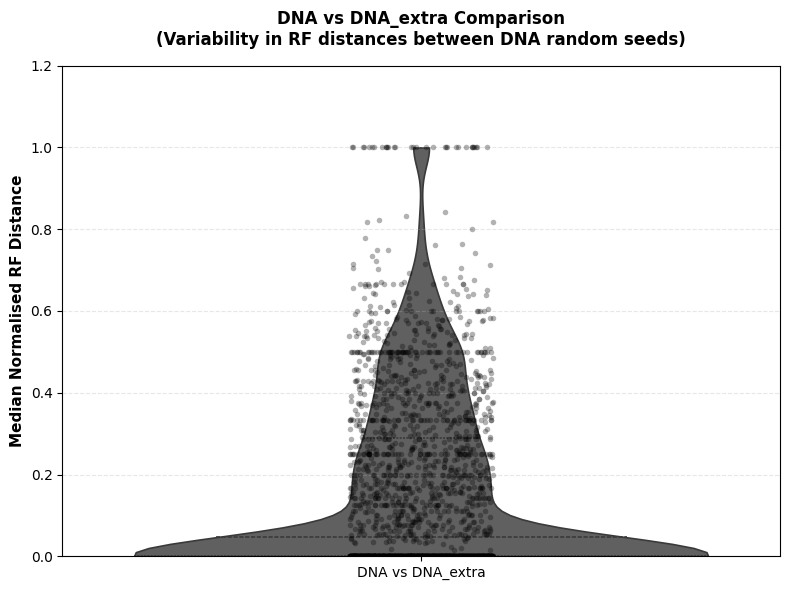


SUMMARY: DNA vs DNA_extra (RF Distance Variability)
N RNA families:        2260
Mean nRF:              0.1653
Median nRF:            0.0465
Std Dev:               0.2203
Min:                   0.0000
Max:                   1.0000

Interpretation:
- This shows how much tree topologies vary between random seeds
- High median nRF → significant seed-induced variation in DNA trees
- Low median nRF → DNA trees robust across different random seeds


In [8]:
#!/usr/bin/env python3
"""
Focused violin plot: DNA vs DNA_extra
Shows variability in median RF distances between DNA and DNA_extra datasets
(representing DNA trees inferred with different random seeds)
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ─── 1) EXTRACT DNA_EXTRA DATA ──────────────────────────────────────────────────
df_dna_extra = seed_medians[
    (seed_medians['Model'] == 'DNA_extra') & 
    (seed_medians['Category'] == 'DNA vs extra DNA')
].copy()

if len(df_dna_extra) == 0:
    print("✗ ERROR: No DNA_extra data found. Check seed_medians dataframe.")
else:
    # ─── 2) PREPARE DATA FOR VIOLIN PLOT ────────────────────────────────────────
    df_dna_extra['Group'] = 'DNA vs DNA_extra'
    
    nrna = len(df_dna_extra)
    n_mean = df_dna_extra['Median nRF'].mean()
    n_median = df_dna_extra['Median nRF'].median()
    n_std = df_dna_extra['Median nRF'].std()
    
    # ─── 3) PLOT: VIOLIN + STRIP ───────────────────────────────────────────────
    plt.figure(figsize=(8, 6))
    
    sns.violinplot(
        data=df_dna_extra,
        x='Group',
        y='Median nRF',
        palette={'DNA vs DNA_extra': '#606060'},  # dark gray
        cut=0,
        inner='quartile',  # show median & IQR
        linewidth=1.2
    )
    
    # Overlay individual RNA points
    sns.stripplot(
        data=df_dna_extra,
        x='Group',
        y='Median nRF',
        color='black',
        alpha=0.3,
        size=4,
        jitter=True
    )
    
    # ─── 4) LABELS & FORMATTING ────────────────────────────────────────────────
    ymax = df_dna_extra['Median nRF'].max()
    plt.ylim(0, ymax * 1.2)
    
    plt.ylabel('Median Normalised RF Distance', fontsize=11, fontweight='bold')
    plt.xlabel('')
    plt.title('DNA vs DNA_extra Comparison\n(Variability in RF distances between DNA random seeds)', 
              fontsize=12, fontweight='bold', pad=15)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # ─── 5) SUMMARY STATISTICS ────────────────────────────────────────────────
    print("\n" + "="*70)
    print("SUMMARY: DNA vs DNA_extra (RF Distance Variability)")
    print("="*70)
    print(f"N RNA families:        {nrna}")
    print(f"Mean nRF:              {n_mean:.4f}")
    print(f"Median nRF:            {n_median:.4f}")
    print(f"Std Dev:               {n_std:.4f}")
    print(f"Min:                   {df_dna_extra['Median nRF'].min():.4f}")
    print(f"Max:                   {df_dna_extra['Median nRF'].max():.4f}")
    print("="*70)
    print("\nInterpretation:")
    print("- This shows how much tree topologies vary between random seeds")
    print("- High median nRF → significant seed-induced variation in DNA trees")
    print("- Low median nRF → DNA trees robust across different random seeds")


## 5. Violin plot of only DNA vs DNA with median nRFs points of RNA families

/var/folders/7l/28yzqfm93j105y85x5rns4bryc93vy/T/ipykernel_31859/1663583315.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


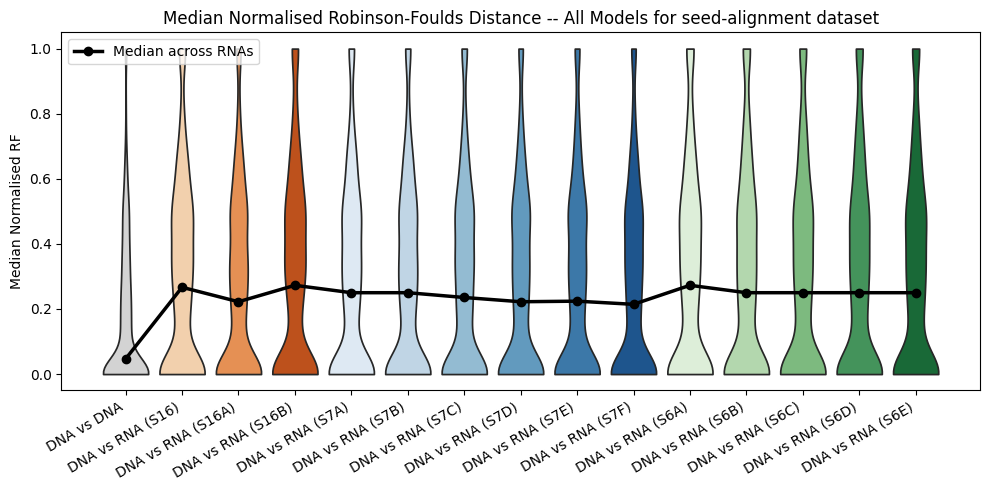

Group medians:
Group
DNA vs DNA           0.0465
DNA vs RNA (S16)     0.2667
DNA vs RNA (S16A)    0.2222
DNA vs RNA (S16B)    0.2727
DNA vs RNA (S7A)     0.2500
DNA vs RNA (S7B)     0.2500
DNA vs RNA (S7C)     0.2353
DNA vs RNA (S7D)     0.2222
DNA vs RNA (S7E)     0.2240
DNA vs RNA (S7F)     0.2143
DNA vs RNA (S6A)     0.2727
DNA vs RNA (S6B)     0.2500
DNA vs RNA (S6C)     0.2500
DNA vs RNA (S6D)     0.2500
DNA vs RNA (S6E)     0.2500
Name: Median nRF, dtype: float64

Group means:
Group
DNA vs DNA           0.1653
DNA vs RNA (S16)     0.2975
DNA vs RNA (S16A)    0.2681
DNA vs RNA (S16B)    0.3018
DNA vs RNA (S7A)     0.2847
DNA vs RNA (S7B)     0.2792
DNA vs RNA (S7C)     0.2788
DNA vs RNA (S7D)     0.2716
DNA vs RNA (S7E)     0.2740
DNA vs RNA (S7F)     0.2689
DNA vs RNA (S6A)     0.3078
DNA vs RNA (S6B)     0.3006
DNA vs RNA (S6C)     0.2991
DNA vs RNA (S6D)     0.2994
DNA vs RNA (S6E)     0.3016
Name: Median nRF, dtype: float64


In [9]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1) Build plotting frame without touching df_medians -----------------------
# Baseline: only from DNA_extra, rename to "DNA vs DNA"
base_mask = (seed_medians['Model'] == 'DNA_extra') & (seed_medians['Category'] == 'DNA vs extra DNA')
df_base = (
    seed_medians.loc[base_mask, ['RNA', 'Median nRF']].copy()
               .assign(Group='DNA vs DNA')
)

# S-models: keep DNA vs RNA rows from all non-DNA_extra models
df_models = seed_medians[
    (seed_medians['Model'] != 'DNA_extra')
    & (seed_medians['Category'].str.startswith('DNA vs RNA'))
].copy()

# Ensure the group label is "DNA vs RNA (MODEL)" (if not already)
def ensure_group(row):
    cat = str(row['Category'])
    if '(' in cat and ')' in cat:
        return cat
    return f"DNA vs RNA ({row['Model']})"

df_models['Group'] = df_models.apply(ensure_group, axis=1)

# Combine for plotting
df_plot = pd.concat(
    [df_base[['RNA','Group','Median nRF']], df_models[['RNA','Group','Median nRF']]],
    ignore_index=True
).dropna(subset=['Median nRF'])

# --- 2) Order groups: baseline → S16* → S7* → S6* ------------------------------
all_groups = sorted(df_plot['Group'].unique())

def pick(prefix):
    return sorted([g for g in all_groups if re.search(rf'\({prefix}', g)],
                  key=lambda g: re.search(r'\(([^)]+)\)', g).group(1))

order = ['DNA vs DNA']
order += pick('S16') + pick('S7') + pick('S6')

# --- 3) Colors -----------------------------------------------------------------
palette = {'DNA vs DNA': '#d3d3d3'}  # light gray baseline

def shade(groups, cmap):
    if not groups: return {}
    cols = sns.color_palette(cmap, len(groups))
    return {g: cols[i] for i, g in enumerate(groups)}

palette |= shade([g for g in order if '(S16' in g], 'Oranges')
palette |= shade([g for g in order if '(S7'  in g], 'Blues')
palette |= shade([g for g in order if '(S6'  in g], 'Greens')

# --- 4) Plot with median trend line ---------------------------------------------------
plt.figure(figsize=(max(10, 0.6*len(order)), 5))
sns.violinplot(
    data=df_plot[df_plot['Group'].isin(order)],
    x='Group', y='Median nRF',
    order=order, palette=palette,
    cut=0,           # cut only at the bottom (no extension below 0)
    inner=None
)

# Add median trend line across groups
xpos = np.arange(len(order))
medians = [df_plot[df_plot['Group'] == g]['Median nRF'].median() for g in order]
plt.plot(xpos, medians, color='black', linewidth=2.5, marker='o', markersize=6, 
         label='Median across RNAs', zorder=10)

plt.xticks(rotation=30, ha='right')
plt.ylabel('Median Normalised RF')
plt.xlabel('')
plt.title('Median Normalised Robinson-Foulds Distance -- All Models for seed-alignment dataset')
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

# --- 5) Quick summaries (optional) ---------------------------------------------
print('Group medians:')
print(df_plot.groupby('Group')['Median nRF'].median().reindex(order).round(4))
print('\nGroup means:')
print(df_plot.groupby('Group')['Median nRF'].mean().reindex(order).round(4))

## 6. Violin plot of representative of RNA models vs DNA model with connecting lines of median nRFs of the same RNA acrros models

/var/folders/7l/28yzqfm93j105y85x5rns4bryc93vy/T/ipykernel_31859/2858893298.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


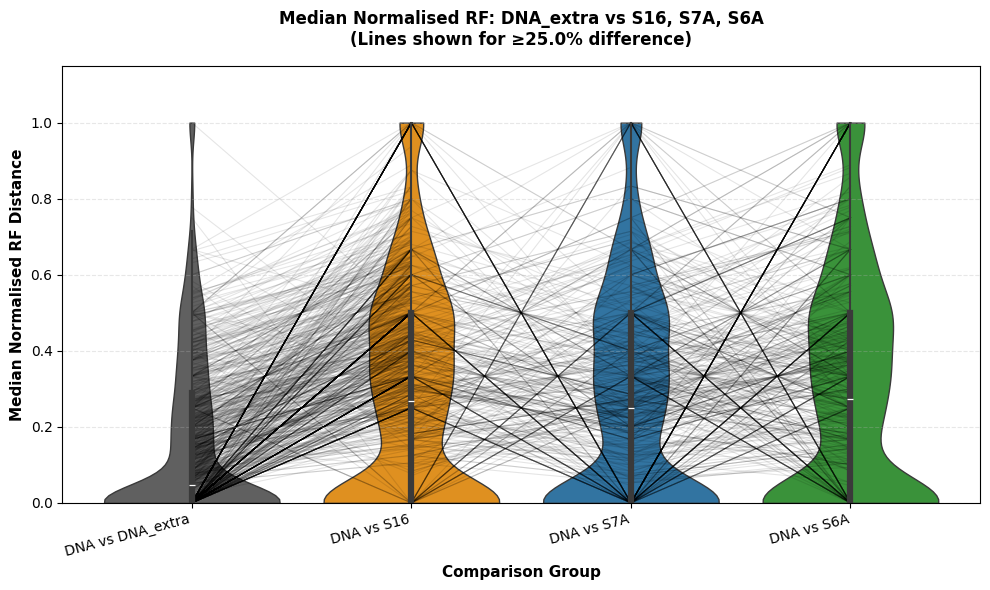


SUMMARY: Median Normalised RF Distances (Selected Models)
RNAs with complete data across all 4 groups: 1788

Median nRF per Comparison Group:
----------------------------------------------------------------------
DNA vs DNA_extra          | N=2260 | Median=0.0465 | Mean=0.1653 | Std=0.2203
DNA vs S16                | N=1788 | Median=0.2667 | Mean=0.2975 | Std=0.2889
DNA vs S7A                | N=1788 | Median=0.2500 | Mean=0.2847 | Std=0.2876
DNA vs S6A                | N=1788 | Median=0.2727 | Mean=0.3078 | Std=0.3011


In [5]:
#!/usr/bin/env python3
"""
Violin plot: DNA_extra, S16, S7A, S6A with connecting lines
Shows median nRF differences across representative models
Lines visible only when difference >= 25% between adjacent groups
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ─── 1) FILTER DATA FOR SELECTED COMPARISONS ───────────────────────────────────
comparisons_to_show = ['DNA vs DNA_extra', 'DNA vs S16', 'DNA vs S7A', 'DNA vs S6A']
groups_order = comparisons_to_show

# Extract data for selected comparisons
df_filtered = seed_medians[seed_medians['Comparison'].isin(comparisons_to_show)].copy()

if len(df_filtered) == 0:
    print("✗ ERROR: No data found for selected comparisons")
else:
    # ─── 2) PIVOT TO WIDE FORMAT FOR CONNECTING LINES ──────────────────────────
    df_wide = df_filtered.pivot(index='RNA', columns='Comparison', values='Median nRF')
    df_wide = df_wide.reindex(columns=groups_order)
    df_wide_complete = df_wide.dropna(how='any')  # keep only RNAs with all 4 groups
    
    # ─── 3) COLOR PALETTE ────────────────────────────────────────────────────────
    palette = {
        'DNA vs DNA_extra': '#606060',  # dark gray
        'DNA vs S16': '#FF9500',        # orange
        'DNA vs S7A': '#1F77B4',        # blue
        'DNA vs S6A': '#2CA02C'         # green
    }
    
    # ─── 4) PLOT: VIOLIN + CONNECTING LINES ──────────────────────────────────────
    plt.figure(figsize=(10, 6))
    
    # Violin plot
    sns.violinplot(
        data=df_filtered,
        x='Comparison',
        y='Median nRF',
        order=groups_order,
        palette=palette,
        cut=0,
        inner='box',  # show median & quartiles
        linewidth=1.0
    )
    
    # Add connecting lines for RNAs with ≥25% difference
    xpos = np.arange(len(groups_order))
    threshold = 0.25  # 25% relative difference threshold
    
    for rna, row in df_wide_complete.iterrows():
        vals = row.values.astype(float)
        
        # Draw lines between adjacent groups
        for i in range(len(vals) - 1):
            v1, v2 = vals[i], vals[i+1]
            
            # Skip if both are NaN
            if np.isnan(v1) or np.isnan(v2):
                continue
            
            # Calculate relative difference
            if v1 == 0 and v2 == 0:
                rel_diff = 0
            elif v1 == 0 or v2 == 0:
                rel_diff = max(abs(v1), abs(v2))  # use absolute value if one is zero
            else:
                rel_diff = abs(v2 - v1) / min(abs(v1), abs(v2))
            
            # Draw line only if difference >= 25%
            if rel_diff >= threshold:
                plt.plot([xpos[i], xpos[i+1]], [v1, v2],
                        color='black', alpha=0.10, linewidth=0.8, zorder=1)
    
    # ─── 5) LABELS & FORMATTING ─────────────────────────────────────────────────
    ymax = df_filtered['Median nRF'].max()
    plt.ylim(0, ymax * 1.15)
    
    plt.xlabel('Comparison Group', fontsize=11, fontweight='bold')
    plt.ylabel('Median Normalised RF Distance', fontsize=11, fontweight='bold')
    plt.title(f'Median Normalised RF: DNA_extra vs S16, S7A, S6A\n(Lines shown for ≥{threshold*100}% difference)', 
              fontsize=12, fontweight='bold', pad=15)
    plt.xticks(rotation=15, ha='right')
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # ─── 6) SUMMARY STATISTICS ──────────────────────────────────────────────────
    print("\n" + "="*70)
    print("SUMMARY: Median Normalised RF Distances (Selected Models)")
    print("="*70)
    print(f"RNAs with complete data across all 4 groups: {len(df_wide_complete)}")
    print("\nMedian nRF per Comparison Group:")
    print("-"*70)
    
    for comp in groups_order:
        data = df_filtered[df_filtered['Comparison'] == comp]['Median nRF']
        print(f"{comp:25} | N={len(data):3} | Median={data.median():.4f} | Mean={data.mean():.4f} | Std={data.std():.4f}")
    
    print("="*70)
